In [31]:
%matplotlib inline

In [32]:
import sys
import os
sys.path.append(os.path.abspath('..'))

In [44]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier

from xgboost import XGBClassifier
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import SGD

from santander.preprocessing import ColumnDropper
from santander.preprocessing import ZERO_VARIANCE_COLUMNS, CORRELATED_COLUMNS

In [34]:
df_train = pd.read_csv('../data/train.csv')
df_target = df_train['TARGET']
df_train = df_train.drop(['TARGET', 'ID'], axis=1)

probs = pd.DataFrame()
errors = pd.DataFrame()

Best log loss train=0.123060 (round=599), test=0.138186 (round=599)
Best AUC train=0.885668 (round=599), test=0.834210 (round=534)


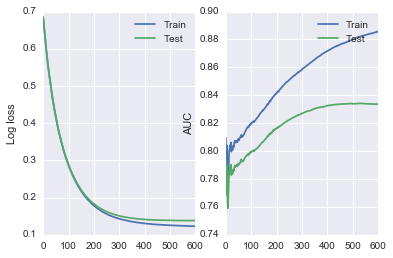

In [35]:
# xgb best params so far using column/row subsampling, even longer training

X_train = df_train.copy()
y_train = df_target
X_train, X_test, y_train, y_test= train_test_split(X_train, y_train, test_size=0.3, random_state=0)

learning_rate = 0.01
n_estimators = 600
max_depth = 6
subsample = 0.9
colsample_bytree = 0.85
min_child_weight = 1  # default

eval_metrics = ['logloss', 'auc']
eval_sets = [(X_train, y_train), (X_test, y_test)]
xgb = XGBClassifier(seed=0, learning_rate=learning_rate, n_estimators=n_estimators,
                    min_child_weight=min_child_weight, max_depth=max_depth,
                    colsample_bytree=colsample_bytree, subsample=subsample)
xgb = xgb.fit(X_train, y_train, eval_metric=eval_metrics, eval_set=eval_sets, verbose=False)

probs['xgb'] = xgb.predict_proba(X_test)[:, -1]

logloss = [xgb.evals_result_['validation_%d' % i]['logloss'] for i in range(len(eval_sets))]
logloss = np.array(logloss, dtype=float).T
auc = [xgb.evals_result_['validation_%d' % i]['auc'] for i in range(len(eval_sets))]
auc = np.array(auc, dtype=float).T

logloss_best_round = np.argmin(logloss, axis=0)
logloss_best = [logloss[logloss_best_round[0], 0], logloss[logloss_best_round[1], 1]]
auc_best_round = np.argmax(auc, axis=0)
auc_best = [auc[auc_best_round[0], 0], auc[auc_best_round[1], 1]]

print 'Best log loss train=%f (round=%d), test=%f (round=%d)' % (logloss_best[0], logloss_best_round[0], logloss_best[1], logloss_best_round[1])
print 'Best AUC train=%f (round=%d), test=%f (round=%d)' % (auc_best[0], auc_best_round[0], auc_best[1], auc_best_round[1])

plt.subplot(1, 2, 1)
plt.plot(logloss)
plt.legend(['Train', 'Test'])
plt.ylabel('Log loss')
plt.subplot(1, 2, 2)
plt.plot(auc)
plt.legend(['Train', 'Test'])
plt.ylabel('AUC')

Best log loss train=0.135867 (epoch=42), test=0.139866 (epoch=45)
Best AUC train=0.842555 (epoch=49), test=0.819725 (epoch=49)


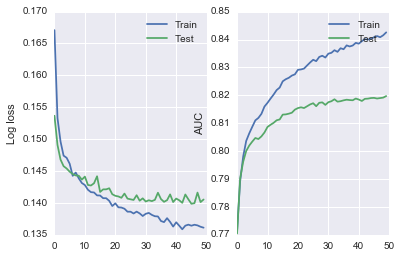

In [36]:
# nn with decent params
# TODO: better cross-validation and save best cross-validated weights

pipeline = Pipeline([
    ('cd', ColumnDropper(drop=ZERO_VARIANCE_COLUMNS+CORRELATED_COLUMNS)),
    ('std', StandardScaler())
])

X_train = pipeline.fit_transform(df_train)
y_train = df_target
X_train, X_test, y_train, y_test= train_test_split(X_train, y_train, test_size=0.3, random_state=0)

nn = Sequential()
nn.add(Dense(32, input_shape=(X_train.shape[1],), activation='sigmoid'))
nn.add(Dropout(0.25))
nn.add(Dense(32, activation='sigmoid'))
nn.add(Dropout(0.25))
nn.add(Dense(1, activation='sigmoid'))

nb_epoch = 50
loss = []
val_loss = []
auc = []
val_auc = []

opt = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
nn.compile(loss='binary_crossentropy', optimizer=opt)

for epoch in range(nb_epoch):
    nn_hist = nn.fit(X_train, y_train, validation_data=(X_test, y_test), nb_epoch=1, verbose=0)
    loss.append(nn_hist.history['loss'])
    val_loss.append(nn_hist.history['val_loss'])
    auc.append([roc_auc_score(y_train, nn.predict_proba(X_train, verbose=0))])
    val_auc.append([roc_auc_score(y_test, nn.predict_proba(X_test, verbose=0))])

probs['nn'] = nn.predict_proba(X_test, verbose=False)[:, -1]
    
print 'Best log loss train=%f (epoch=%d), test=%f (epoch=%d)' % (np.min(loss), np.argmin(loss), np.min(val_loss), np.argmin(val_loss))
print 'Best AUC train=%f (epoch=%d), test=%f (epoch=%d)' % (np.max(auc), np.argmax(auc), np.max(val_auc), np.argmax(val_auc)) 

plt.subplot(1, 2, 1)
plt.plot(np.hstack([loss, val_loss]))
plt.legend(['Train', 'Test'])
plt.ylabel('Log loss')
plt.subplot(1, 2, 2)
plt.plot(np.hstack([auc, val_auc]))
plt.legend(['Train', 'Test'])
plt.ylabel('AUC')

In [43]:
# knn with extreme bagging improves quite a bit over standard knn on subset of pca features

pipeline = Pipeline([
    ('cd', ColumnDropper(drop=ZERO_VARIANCE_COLUMNS+CORRELATED_COLUMNS)),
    ('std', StandardScaler()),
    ('pca', PCA(n_components=0.6))
])

X_train = pipeline.fit_transform(df_train)
y_train = df_target
X_train, X_test, y_train, y_test= train_test_split(X_train, y_train, test_size=0.3, random_state=0)

knn = KNeighborsClassifier(n_jobs=-1)
knn.fit(X_train, y_train)
print 'KNN: %f' % roc_auc_score(y_test, knn.predict_proba(X_test)[:, 1])

knn_bag = BaggingClassifier(KNeighborsClassifier(n_jobs=-1), max_samples=0.01, max_features=0.9, n_estimators=250, random_state=0)
knn_bag = knn_bag.fit(X_train, y_train)
print 'KNN bag: %f' % roc_auc_score(y_test, knn_bag.predict_proba(X_test)[:, -1])

probs['knn'] = knn_bag.predict_proba(X_test)[:, -1]

KNN: 0.639356
KNN bag: 0.796141


In [74]:
# lr (balanced -- should probably try balancing other classifiers too)

pipeline = Pipeline([
    ('cd', ColumnDropper(drop=ZERO_VARIANCE_COLUMNS+CORRELATED_COLUMNS)),
    ('std', StandardScaler()),
    ('pca', PCA(n_components=0.95))
])

X_train = pipeline.fit_transform(df_train)
y_train = df_target
X_train, X_test, y_train, y_test= train_test_split(X_train, y_train, test_size=0.3, random_state=0)

lr = LogisticRegression(class_weight='balanced')
lr = lr.fit(X_train, y_train)
print 'LR: %f' % roc_auc_score(y_test, lr.predict_proba(X_test)[:, 1])

probs['lr'] = lr.predict_proba(X_test)[:, -1]

LR: 0.798429


          xgb        nn       knn        lr
xgb  1.000000  0.894266  0.811753  0.694191
nn   0.894266  1.000000  0.846162  0.793016
knn  0.811753  0.846162  1.000000  0.695961
lr   0.694191  0.793016  0.695961  1.000000


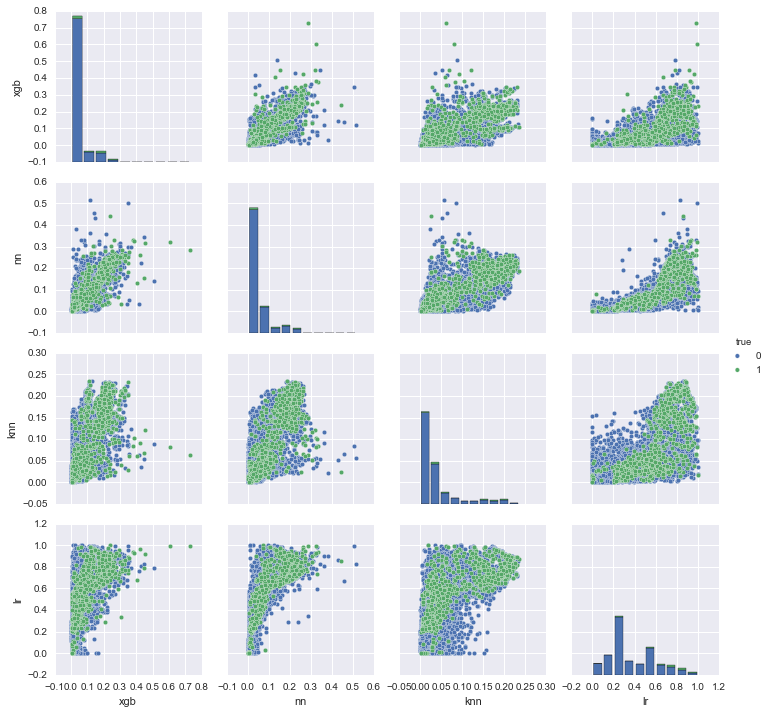

In [73]:
# knn doesn't deal with outliers well -- will need more preprocessing
# this visualization isn't very informative though -- need error analysis

probs['true'] = y_test.values
print probs.drop('true', axis=1).corr()
sns.pairplot(probs, vars=probs.drop('true', axis=1).columns, hue='true')

In [67]:
# hand-ensembling
roc_auc_score(probs['true'], probs['xgb']*0.8 + probs['nn']*0.1 + probs['knn']*0.1)

0.84068785955802128